# K-means

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sio
import numpy as np

In [8]:
mat = sio.loadmat('ex7data2.mat')

In [9]:
data = pd.DataFrame(mat.get('X'), columns=['X1', 'X2'])

In [10]:
data.sample(3)

,X1,X2
119,2.543715,0.957327
167,2.144911,1.135824
252,6.010180,2.724013


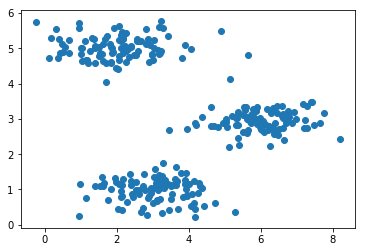

In [11]:
plt.scatter(data.X1, data.X2)

### Helper functions

In [12]:
def combine_data_C(data, C):
    """combine C (centoid number which a sample belongs to) with data"""
    data_with_c = data.copy()
    data_with_c['C'] = C
    return data_with_c

def cost(data, centroids, C):
    """calculate cost of current cluster state"""
    m = data.shape[0]
    expand_C_with_centroids = centroids[C]
    distances = np.apply_along_axis(np.linalg.norm, # this function returns l2 norm
                                    axis=1, 
                                    arr=data.values - expand_C_with_centroids
                                   )
    return distances.sum() / m

### Step 1: Randomly choose k centroids from data set

In [13]:
def random_init(data, k):
    return data.sample(k).values

In [14]:
init_centroids = random_init(data, 3)
init_centroids

array([[3.27844295, 1.75043926],
       [5.3627205 , 3.14681192],
       [2.02134502, 4.41267445]])

### Step 2: Assign cluster 

In [15]:
def _find_your_cluster(x, centroids):
    """find which centoid the sample belongs to. choose the one with lowest l2 norm"""
    distances = np.apply_along_axis(func1d=np.linalg.norm, # this function returns l2 norm
                                    axis=1, 
                                    arr=centroids - x # numpy broadcast
                                   )
    return np.argmin(distances)

def assign_cluster(data, centroids):
    """
    assign cluster for each node in data.
    """
    return np.apply_along_axis(lambda x: _find_your_cluster(x, centroids), 
                               axis=1, 
                               arr=data.values)

In [16]:
C = assign_cluster(data, init_centroids)
data_with_c = combine_data_C(data, C)
print(cost(data, init_centroids, C))
data_with_c.sample(3)

1.0400229188558638


,X1,X2,C
115,2.951770,0.895831,0
25,2.178936,5.297587,2
160,3.936160,1.462029,0


### Step 3: Calculate new centroids 

In [17]:
def new_centroids(data, C):
    """calculate new centroids"""
    data_with_c = combine_data_C(data, C)
    return data_with_c.groupby('C', as_index=False).mean().sort_values(by='C').drop('C', axis=1).values


In [18]:
centroids = new_centroids(data, C)
print(cost(data, centroids, C))
centroids

0.794176363371587


array([[3.04367119, 1.01541041],
       [6.03366736, 3.00052511],
       [1.95399466, 5.02557006]])

# Iterate througn step 2 to step3

In [19]:
def _k_means_iter(data, k, epoch=100, tol=0.0001):
    """one shot k-means with early break
    Parameters:
        data: DataFrame -> raw data
        k: int -> number of clusters
        epoch: int -> max number of iterations
        tol: float -> improvement over last iteration
    """
    centroids = random_init(data, k)
    cost_progress = []
    for i in range(epoch):
        # cluster assign
        C = assign_cluster(data, centroids)
        
        # calculate the cost 
        cost_progress.append(cost(data, centroids, C))
        print('running epoch {}, {}'.format(i, cost_progress[-1]))
        
        # calculate new centroids
        centroids = new_centroids(data, C)
        
        if len(cost_progress) > 1: # at least two iteration
            if (np.abs(cost_progress[-1] - cost_progress[-2])) / cost_progress[-1] < tol: # nothing to improve
                break
        
    return C, centroids, cost_progress[-1]

running epoch 0, 1.7964720713984412
running epoch 1, 1.2366431449239264
running epoch 2, 0.8732996469849419
running epoch 3, 0.7935928938302486
running epoch 4, 0.794176363371587
running epoch 5, 0.794176363371587


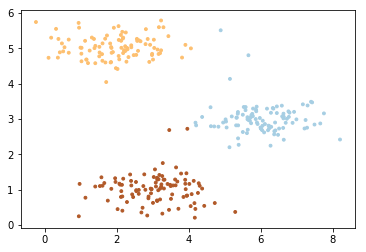

In [20]:
C, centroids, _ = _k_means_iter(data, 3, 20)
plt.scatter(data.X1, data.X2, s=8, c=C, cmap="Paired")

## Multiple random initialization
K-means might stuck in local optimal, so we need several random initialization to avoid that

In [21]:
def k_means(data, k, epoch=100, n_init=5):
    """do multiple random init and pick the best one to return"""
    tries = np.array([_k_means_iter(data, k, epoch) for _ in range(n_init)])
    least_cost_idx = np.argmin(tries[:, -1])
    print("least cost idx: ", least_cost_idx)
    return tries[least_cost_idx]

running epoch 0, 1.5270031501612262
running epoch 1, 1.4978246568009341
running epoch 2, 1.461756108454274
running epoch 3, 1.4600470292904584
running epoch 4, 1.459802667515615
running epoch 5, 1.4596820336276082
running epoch 0, 1.9093171570998837
running epoch 1, 1.4952592551836572
running epoch 2, 1.4612098443426171
running epoch 3, 1.4596193410249212
running epoch 4, 1.4596193410249212
running epoch 0, 1.7272028413799854
running epoch 1, 1.4637251948125183
running epoch 2, 1.4610787976088766
running epoch 3, 1.4609658644589
running epoch 0, 1.6650231420022996
running epoch 1, 1.425335527886573
running epoch 2, 0.79854766984709
running epoch 3, 0.794176363371587
running epoch 4, 0.794176363371587
running epoch 0, 1.8248664005113187
running epoch 1, 1.4640572719983138
running epoch 2, 1.46057293049808
running epoch 3, 1.459465757575749
running epoch 4, 1.4596193410249212
running epoch 5, 1.4596193410249212
least cost idx:  3


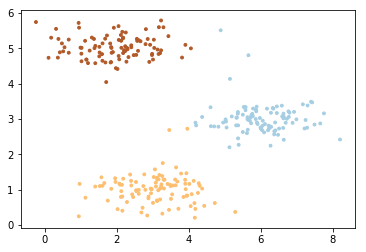

In [22]:
least_cost_C, least_cost_centroids, least_cost = k_means(data, 3, 20, 5)
plt.scatter(data.X1, data.X2, s=8, c=least_cost_C, cmap='Paired')